In [3]:
# Import necessary modules

import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter, CoxPHFitter
import matplotlib.pyplot as plt
import seaborn as sns

# Load the Rossi dataset
data = pd.read_excel("RADCURE_Clinical_v04_20241219.xlsx")
data.to_csv("RADCURE_Clinical_v04_20241219.csv", index=False)
data.head()

if "OS_time" in data.columns:
    print("The 'OS_time' column exists.")


In [9]:
# Identify survival time and event columns
print("Column Names:")
print(data.columns.tolist())

# Rename the columns
data = data.rename(columns={"Length FU": "Survival_Time", "Status": "Event"})
#print(data["Event"].unique()) 

# Check data types
#print(data[["Survival_Time", "Event"]].dtypes)

# Convert the data types for the event columns
data["Event"] = data["Event"].astype(str).str.strip().str.lower()
data["Event"] = data["Event"].map({"dead": 1, "alive": 0})
#print(data["Event"].unique()) 

# Check for missing values
#print(data[["Survival_Time", "Event"]].isnull().sum())


# Define the survival time and event columns
time_column = "Survival_Time"
event_column = "Event"



Column Names:
['patient_id', 'Age', 'Sex', 'ECOG PS', 'Smoking PY', 'Smoking Status', 'Ds Site', 'Subsite', 'T', 'N', 'M ', 'Stage', 'Path', 'HPV', 'Tx Modality', 'Chemo', 'RT Start', 'Dose', 'Fx', 'Last FU', 'Event', 'Survival_Time', 'Date of Death', 'Cause of Death', 'Local', 'Date Local', 'Regional', 'Date Regional', 'Distant', 'Date Distant', '2nd Ca', 'Date 2nd Ca', 'RADCURE-challenge', 'ContrastEnhanced', 'Age_Group']


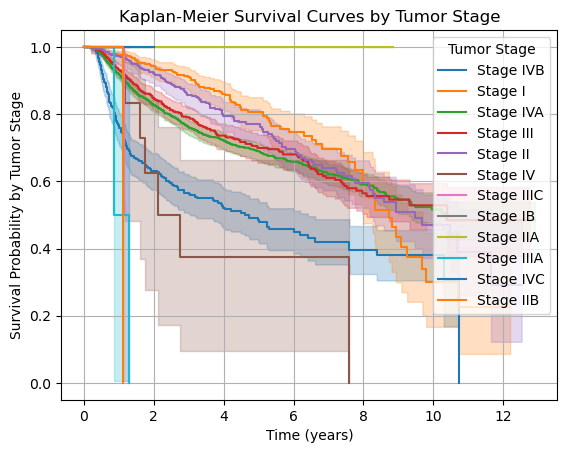

Log-Rank Test between Stage IVB and Stage I: p-value = 1.0000
Log-Rank Test between Stage IVB and Stage IVA: p-value = 1.0000
Log-Rank Test between Stage IVB and Stage III: p-value = 1.0000
Log-Rank Test between Stage IVB and Stage II: p-value = 1.0000
Log-Rank Test between Stage IVB and Stage IV: p-value = 1.0000
Log-Rank Test between Stage IVB and Stage IIIC: p-value = 1.0000
Log-Rank Test between Stage IVB and Stage IB: p-value = 1.0000
Log-Rank Test between Stage IVB and Stage IIA: p-value = 1.0000
Log-Rank Test between Stage IVB and Stage IIIA: p-value = 1.0000
Log-Rank Test between Stage IVB and Stage IVC: p-value = 1.0000
Log-Rank Test between Stage IVB and Stage IIB: p-value = 1.0000
Log-Rank Test between Stage I and Stage IVA: p-value = 1.0000
Log-Rank Test between Stage I and Stage III: p-value = 1.0000
Log-Rank Test between Stage I and Stage II: p-value = 1.0000
Log-Rank Test between Stage I and Stage IV: p-value = 1.0000
Log-Rank Test between Stage I and Stage IIIC: p-value

In [12]:
from lifelines.statistics import logrank_test 
# Fit the Kaplan-Meier estimator
kmf = KaplanMeierFitter()
#print("Stage column dtype:", data["Stage"].dtype)


# 1. Generage Kaplan-Meier Curve for tumor stage
# Check for missing values in the stage column
data["Stage"] = data["Stage"].astype(str).str.strip()
#print(data["Stage"].unique())
#print(data[["Stage"]].isnull().sum())

# Remove missing values
data = data[~data["Stage"].isin(["nan", "0", "X"])]
#print(data["Stage"].unique())

tumor_stage = data["Stage"].unique()
survival_data_stage = {}

for stage in tumor_stage:
    group_data = data[data["Stage"] == stage]
    kmf.fit(group_data["Survival_Time"], event_observed=group_data["Event"], label=f"Stage {stage}")
    kmf.plot_survival_function()
    survival_data_stage[stage] = subset

plt.title("Kaplan-Meier Survival Curves by Tumor Stage")
plt.xlabel("Time (years)")
plt.ylabel("Survival Probability by Tumor Stage")
plt.legend(title="Tumor Stage")
plt.grid(True)
plt.show()

#  Log-Rank Test for Tumor Stages
for i in range(len(tumor_stage)):
    for j in range(i + 1, len(tumor_stage)):
        stage1, stage2 = tumor_stage[i], tumor_stage[j]
        
        if stage1 in survival_data_stage and stage2 in survival_data_stage:
            result = logrank_test(
                survival_data_stage[stage1]["Survival_Time"],
                survival_data_stage[stage2]["Survival_Time"],
                event_observed_A=survival_data_stage[stage1]["Event"],
                event_observed_B=survival_data_stage[stage2]["Event"]
            )
            print(f"Log-Rank Test between Stage {stage1} and Stage {stage2}: p-value = {result.p_value:.4f}")



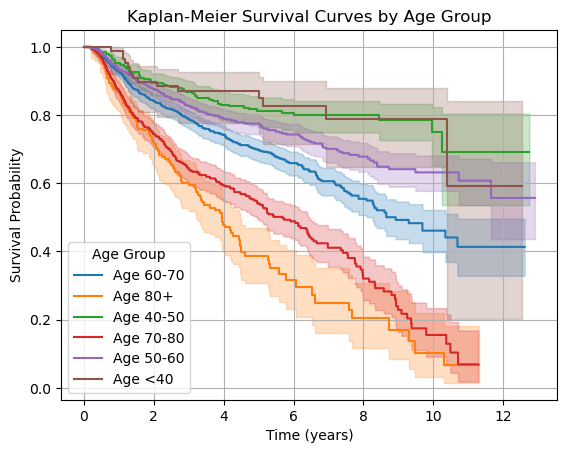

Log-Rank Test between 60-70 and 80+: p-value = 0.0000
Log-Rank Test between 60-70 and 40-50: p-value = 0.0000
Log-Rank Test between 60-70 and 70-80: p-value = 0.0000
Log-Rank Test between 60-70 and 50-60: p-value = 0.0001
Log-Rank Test between 60-70 and <40: p-value = 0.0020
Log-Rank Test between 80+ and 40-50: p-value = 0.0000
Log-Rank Test between 80+ and 70-80: p-value = 0.0111
Log-Rank Test between 80+ and 50-60: p-value = 0.0000
Log-Rank Test between 80+ and <40: p-value = 0.0000
Log-Rank Test between 40-50 and 70-80: p-value = 0.0000
Log-Rank Test between 40-50 and 50-60: p-value = 0.0093
Log-Rank Test between 40-50 and <40: p-value = 0.8085
Log-Rank Test between 70-80 and 50-60: p-value = 0.0000
Log-Rank Test between 70-80 and <40: p-value = 0.0000
Log-Rank Test between 50-60 and <40: p-value = 0.1004


In [13]:

# 2. Generate Kaplan-Meier survival curves for tumor stage

# Bin Age into groups
data["Age"] = pd.to_numeric(data["Age"], errors="coerce")
bins = [0, 40, 50, 60, 70, 80, 100] 
labels = ["<40", "40-50", "50-60", "60-70", "70-80", "80+"]

# Assign age groups
data["Age_Group"] = pd.cut(data["Age"], bins=bins, labels=labels)

# Remove missing values
data = data.dropna(subset=["Age_Group"])

# Get unique age groups
age_groups = data["Age_Group"].unique()
survival_age = {}
for group in age_groups:
    subset = data[data["Age_Group"] == group]
    kmf.fit(subset["Survival_Time"], event_observed=subset["Event"], label=f"Age {group}")
    kmf.plot_survival_function()
    survival_age[group] = subset

# Get plot
plt.title("Kaplan-Meier Survival Curves by Age Group")
plt.xlabel("Time (years)")
plt.ylabel("Survival Probability")
plt.legend(title="Age Group")
plt.grid(True)
plt.show()

for i in range(len(age_groups)):
    for j in range(i + 1, len(age_groups)):
        group1, group2 = age_groups[i], age_groups[j]
        
        if group1 in survival_age and group2 in survival_age:
            result = logrank_test(
                survival_age[group1]["Survival_Time"],
                survival_age[group2]["Survival_Time"],
                event_observed_A=survival_age[group1]["Event"],
                event_observed_B=survival_age[group2]["Event"]
            )
            print(f"Log-Rank Test between {group1} and {group2}: p-value = {result.p_value:.4f}")

        

Unique values in Survival_Time:
 [1.31780822 1.52054794 2.1260274  ... 8.1890411  5.73972603 5.82465753] 

Unique values in Event:
 [1 0] 

Unique values in Age:
 [62.6 87.3 49.9 72.3 59.7 61.  77.4 70.8 70.2 71.  68.7 90.  69.3 69.
 64.8 54.4 62.1 73.8 63.2 65.6 58.1 65.8 70.  79.6 71.4 75.8 69.9 62.
 66.7 64.7 61.8 57.1 75.6 68.1 63.5 73.2 74.4 58.5 63.6 65.7 57.2 67.5
 68.2 68.8 78.1 73.1 73.5 80.  60.1 68.5 78.5 67.3 58.3 55.5 45.8 63.7
 66.4 56.6 58.7 55.4 75.  50.  66.3 69.2 49.3 48.2 60.7 79.8 75.2 63.9
 64.1 63.1 48.1 50.9 53.2 67.8 55.6 47.3 55.3 69.7 62.4 60.9 77.2 52.7
 60.3 62.9 64.5 51.2 63.3 79.4 68.  64.3 61.1 74.5 56.3 77.1 77.9 83.9
 69.5 57.9 72.2 51.7 51.4 76.  79.1 65.2 61.6 45.9 64.2 56.2 55.9 54.5
 63.4 59.8 53.4 65.  49.7 54.9 64.9 58.  59.3 81.4 62.8 46.3 71.1 51.9
 63.  58.8 57.7 74.  61.5 75.1 77.  59.6 72.  58.4 61.9 84.6 60.8 57.4
 71.2 46.7 52.8 62.3 77.7 56.8 71.3 52.4 54.6 73.7 79.3 59.  67.  87.4
 59.5 77.6 69.4 62.7 53.9 81.  60.2 78.7 65.9 75.7 47.  39

<lifelines.CoxPHFitter: fitted with 3217 total observations, 2198 right-censored observations>
             duration col = 'Survival_Time'
                event col = 'Event'
      baseline estimation = breslow
   number of observations = 3217
number of events observed = 1019
   partial log-likelihood = -7457.71
         time fit was run = 2025-03-15 00:24:31 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
Age         0.03      1.03      0.00            0.03            0.04                1.03                1.04
Chemo      -0.27      0.76      0.08           -0.42           -0.12                0.66                0.89
Smoking PY  0.01      1.01      0.00            0.01            0.01                1.01                1.01

            cmp to     z      p  -log2(p)
covariate                                
Age           0.00  9.76 <0.005     72.41
Chemo         0.00 -3.49 <0.005     11.04
Smoking PY    0.00 10.52 <0.005     83.64
---
Concordance = 0.66
Partial AIC = 14921.42
log-likelihood ratio test = 360.20 on 3 df
-log2(p) of ll-ratio test = 255.91

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 3217 total observations, 2198 right-censored observations>
         test_name = proportional_hazard_test

---
                 test_statistic      p  -log2(p)
Age        km             10.03 <0.005      9.34
           rank            9.43 <0.005      8.87
Chemo      km              2.27   0.13      2.92
           rank            0.67   0.41      1.27
Smoking PY km              0.13   0.72      0.48
           rank            0.30   0.58      0.78



1. Variable 'Age' failed the non-proportional test: p-value is 0.0015.

   Advice 1: the functional form of the variable 'Age' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'Age' using pd.cut, and then specify it in `strata=['Age',
...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Introduce-time-varyi

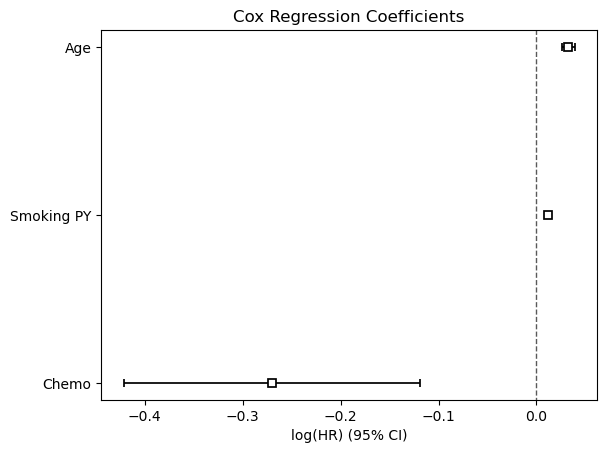

In [108]:

# Select relevant columns
cox_data = data[["Survival_Time", "Event", "Age", "Chemo", "Smoking PY"]].copy()

# Drop missing values in Smoking PY
cox_data = cox_data.dropna(subset=["Smoking PY"])

# Ensure Chemo is binary
cox_data["Chemo"] = cox_data["Chemo"].astype(str).str.strip().str.lower()
cox_data["Chemo"] = cox_data["Chemo"].map({"yes": 1, "no": 0, "none": 0})

# Convert everything to numeric to remove 'na' errors
cox_data = cox_data.apply(pd.to_numeric, errors="coerce")

# Drop remaining NaNs
cox_data = cox_data.dropna()

# Check if there are any non-numeric values left
for col in cox_data.columns:
    print(f"Unique values in {col}:\n", cox_data[col].unique(), "\n")

# Fit the Cox Proportional Hazards Model
cph = CoxPHFitter()
cph.fit(cox_data, duration_col="Survival_Time", event_col="Event")

# Print model summary and check the proportional hazards assumption
cph.print_summary()
cph.check_assumptions(cox_data, p_value_threshold=0.05)


# Plot the coefficients
cph.plot()
plt.title("Cox Regression Coefficients")
plt.show()


Age               float64
Sex                object
Smoking PY         object
Smoking Status     object
Ds Site            object
Subsite            object
Stage              object
HPV                object
Tx Modality        object
Chemo              object
Dose              float64
Fx                  int64
Event               int64
Survival_Time     float64
Cause of Death     object
dtype: object
Random Survival Forest C-index: 0.7521


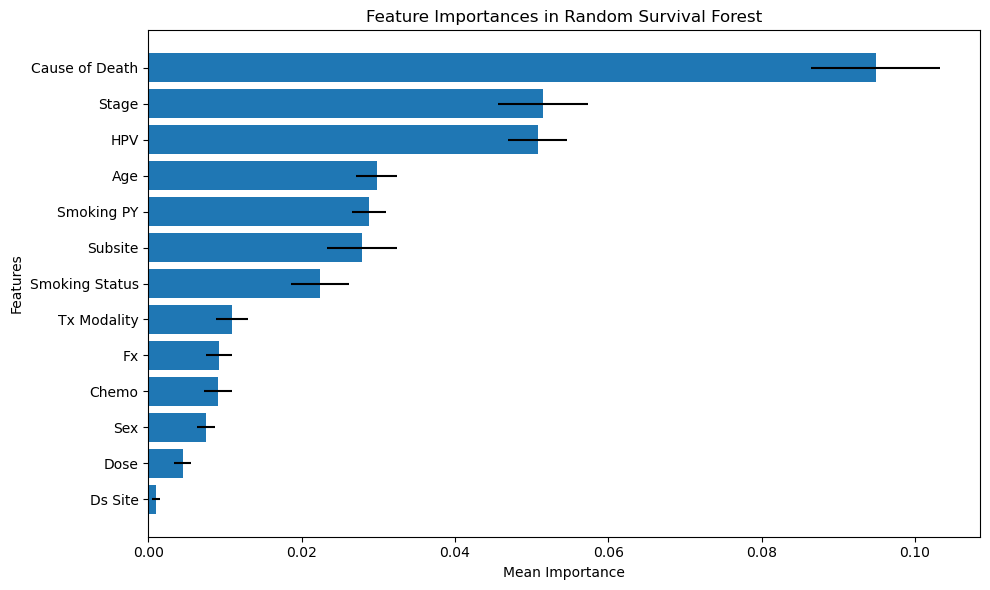

Cox Regression C-index: 0.6539
Random Survival Forest C-index: 0.7521


In [100]:
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored
from sklearn.inspection import permutation_importance

# Load dataset
rsf_data = data.copy()

# Fix column names 
rsf_data.columns = rsf_data.columns.str.strip()

# Drop non-informative columns
drop_cols = [
    "patient_id", "RT Start", "Date of Death", "Last FU", "Local", "Date Local", "Distant",
    "Date Regional", "Date Distant", "Date 2nd Ca", "2nd Ca", "RADCURE-challenge", "ContrastEnhanced",
    "Regional", "ECOG PS", "T", "N", "M", "Path", "Age_Group"
]
rsf_data = rsf_data.drop(columns=drop_cols, errors="ignore")

# Check data types for columns in rsf_data
print(rsf_data.dtypes)

# Convert categorical variables to numerical values
categorical_cols = ["Stage", "Sex", "Smoking Status", "Ds Site", "Subsite", "HPV", "Tx Modality", "Cause of Death"]

for col in categorical_cols:
    rsf_data[col] = rsf_data[col].astype("category").cat.codes
    rsf_data[col] = rsf_data[col].replace(-1, np.nan)  

# Handle "Smoking PY" values with non-numeric values
rsf_data["Smoking PY"] = rsf_data["Smoking PY"].astype(str).str.extract(r'(\d+)').astype(float)

# Convert "Chemo" column to binary format
rsf_data["Chemo"] = rsf_data["Chemo"].astype(str).str.strip().str.lower().map({"yes": 1, "none": 0})

# Ensure Survival_Time and Event are numeric
rsf_data["Survival_Time"] = pd.to_numeric(rsf_data["Survival_Time"], errors="coerce")
rsf_data["Event"] = pd.to_numeric(rsf_data["Event"], errors="coerce")

# Drop missing values
rsf_data = rsf_data.dropna()

# Convert survival data into structured array format for sksurv
rsf_target = np.array([(bool(event), time) for event, time in zip(rsf_data["Event"], rsf_data["Survival_Time"])], 
                      dtype=[('event', bool), ('time', float)])

# Select all features except survival-related columns
rsf_features = rsf_data.drop(columns=["Survival_Time", "Event"])

# Remove constant columns
rsf_features = rsf_features.loc[:, rsf_features.nunique() > 1]

# Initialize and fit RSF model
rsf = RandomSurvivalForest(n_estimators=200, min_samples_split=10, min_samples_leaf=5, n_jobs=-1, random_state=42)
rsf.fit(rsf_features, rsf_target)

# Predict risk scores
rsf_risk_scores = rsf.predict(rsf_features)

# Compute Concordance Index (C-index) for RSF
rsf_cindex = concordance_index_censored(rsf_target["event"], rsf_target["time"], rsf_risk_scores)[0]
print(f"Random Survival Forest C-index: {rsf_cindex:.4f}")

# Compute permutation importance 
result = permutation_importance(
    rsf, rsf_features, rsf_target, n_repeats=15, random_state=42, n_jobs=1
)

# Create DataFrame with feature importances
feature_importance = pd.DataFrame(
    {k: result[k] for k in ("importances_mean", "importances_std")},
    index=rsf_features.columns,
).sort_values(by="importances_mean", ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances in Random Survival Forest")
plt.barh(
    feature_importance.index,
    feature_importance["importances_mean"],
    xerr=feature_importance["importances_std"],
    align="center",
)
plt.xlabel("Mean Importance")
plt.ylabel("Features")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Compare with Cox Regression
from lifelines import CoxPHFitter

# Fit Cox model
cph = CoxPHFitter()
cox_data = rsf_data.copy()  
cph.fit(cox_data, duration_col="Survival_Time", event_col="Event")

# Compute C-index for Cox model
cox_cindex = cph.concordance_index_

print(f"Cox Regression C-index: {cox_cindex:.4f}")
print(f"Random Survival Forest C-index: {rsf_cindex:.4f}")
